# **Setup & Dependencies**

In [3]:
import os
import math
import copy
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Loading & Frame Building**

In [4]:
def load_and_preprocess_data(filepath, frame_size=100):
    data = pd.read_excel(filepath)

    # Normalize selected accelerometer columns
    acc_cols = ['right acceleration X[g]', 'right acceleration Y[g]', 'right acceleration Z[g]']
    scaler = StandardScaler()
    data[acc_cols] = scaler.fit_transform(data[acc_cols])

    labels = data['label'].values
    class_weights = compute_class_weights(labels)

    all_frames, all_labels = [], []

    # Segment data into fixed-size frames
    for i in range(0, len(data), frame_size):
        segment = data.iloc[i:i + frame_size]
        frame = segment[acc_cols].values.flatten()
        label = np.bincount(segment['label']).argmax()  # Majority label for the frame
        all_frames.append(frame)
        all_labels.append(label)

    return np.array(all_frames), np.array(all_labels), class_weights, data


def build_a_frame_dict(all_frames, all_labels):
    a_frame = {i: [] for i in range(all_frames.shape[1])}
    a_frame['label'] = []

    for frame, label in zip(all_frames, all_labels):
        for i, val in enumerate(frame):
            a_frame[i].append(val)
        a_frame['label'].append(label)

    return pd.DataFrame(a_frame)


def compute_class_weights(labels):
    label_counts = np.bincount(labels)
    total = len(labels)

    # Weight = total / (2 * count) to handle class imbalance
    weights = [total / (2 * c) if c > 0 else 0 for c in label_counts]
    return torch.tensor(weights, dtype=torch.float32)


# **Dataset & DataLoader**

In [5]:
class IMUDataset(Dataset):
    def __init__(self, x, y, onehot=False):
        # Reshape input to (samples, sequence_length=100, features=3)
        self.X = torch.tensor(x, dtype=torch.float32).reshape(-1, 100, 3)
        self.Y = torch.tensor(y, dtype=torch.long).squeeze()

        if onehot:
            # Optionally convert labels to one-hot encoding
            encoder = OneHotEncoder(sparse=False)
            y_encoded = encoder.fit_transform(y.reshape(-1, 1))
            self.Y = torch.tensor(y_encoded, dtype=torch.float32)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


def prepare_dataloaders(df, batch_size=8, onehot=False):
    x = df.iloc[:, :-1].values
    y = df['label'].values

    # Split into train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

    train_set = IMUDataset(x_train, y_train, onehot)
    val_set = IMUDataset(x_val, y_val, onehot)

    return {
        'train': DataLoader(train_set, batch_size=batch_size, shuffle=True),
        'val': DataLoader(val_set, batch_size=batch_size, shuffle=False)
    }


# **Transformer Model**

In [6]:
class ScaleDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v):
        # Compute scaled dot-product attention
        d_k = q.size(-1)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
        attn = self.softmax(scores)
        return torch.matmul(attn, v), attn


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        self.n_head = n_head
        self.attn = ScaleDotProductAttention()
        self.qkv_proj = nn.Linear(d_model, d_model * 3)  # Combine Q, K, V projections
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv_proj(x).reshape(B, T, self.n_head, -1).permute(2, 0, 1, 3)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        out, _ = self.attn(q, k, v)
        out = out.permute(1, 2, 0, 3).reshape(B, T, C)
        return self.out_proj(out)


class LayerNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = 1e-6

    def forward(self, x):
        # Normalize across the last dimension
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden_dim):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, d_model)
        )

    def forward(self, x):
        return self.ffn(x)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # Precompute sinusoidal positional encodings
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, ffn_hidden):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_head)
        self.norm1 = LayerNorm(d_model)
        self.ffn = PositionwiseFeedForward(d_model, ffn_hidden)
        self.norm2 = LayerNorm(d_model)

    def forward(self, x):
        x = self.norm1(x + self.attn(x))  # Add & Norm after attention
        x = self.norm2(x + self.ffn(x))   # Add & Norm after FFN
        return x


class Encoder(nn.Module):
    def __init__(self, d_model, n_head, ffn_hidden, n_layers):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_head, ffn_hidden)
            for _ in range(n_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class TransformerModel(nn.Module):
    def __init__(self, d_model=64, n_head=2, n_layers=2, seq_len=100, ffn_hidden=128, num_classes=2):
        super().__init__()
        self.input_proj = nn.Linear(3, d_model)  # Project 3D input to model dimension
        self.pos_enc = PositionalEncoding(d_model)
        self.encoder = Encoder(d_model, n_head, ffn_hidden, n_layers)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d_model * seq_len, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_enc(x)
        x = self.encoder(x)
        return self.classifier(x)


# **Training & Evaluation**

In [8]:
def calc_loss_and_score(outputs, targets, class_weights, metrics):
    # Cross-entropy loss with class weights
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    loss = loss_fn(outputs, targets)

    metrics['loss'].append(loss.item())
    _, preds = torch.max(outputs, 1)
    metrics['correct'] += (preds == targets).sum().item()
    metrics['total'] += targets.size(0)

    return loss


def train_model(model, dataloaders, optimizer, class_weights, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    history = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print('-' * 30)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            metrics = {'loss': [], 'correct': 0, 'total': 0}

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss_and_score(outputs, labels, class_weights, metrics)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            epoch_loss = np.mean(metrics['loss'])
            epoch_acc = 100 * metrics['correct'] / metrics['total']
            history[phase].append((epoch_loss, epoch_acc))

            # Save model if it improves on validation loss
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print(" Best model updated!")

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

    model.load_state_dict(best_model_wts)
    return model, history


def evaluate_and_plot_confusion_matrix(model, dataloader, class_names=None, save_path=None):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute performance metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print("\nFinal Validation Metrics:")
    print(f"Accuracy : {acc * 100:.2f}%")
    print(f"Precision: {prec * 100:.2f}%")
    print(f"Recall   : {rec * 100:.2f}%")
    print(f"F1 Score : {f1 * 100:.2f}%")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to: {save_path}")
    plt.show()


def plot_metrics(history):
    # Unpack history
    epochs = range(1, len(history['train']) + 1)
    train_loss, train_acc = zip(*history['train'])
    val_loss, val_acc = zip(*history['val'])

    # Plot loss and accuracy trends
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, val_loss, label='Val')
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train')
    plt.plot(epochs, val_acc, label='Val')
    plt.title("Accuracy Over Epochs")
    plt.legend()
    plt.show()


# **Run Everything**


Epoch 1/50
------------------------------
Train Loss: 0.6600 | Accuracy: 61.00%
 Best model updated!
Val Loss: 0.6096 | Accuracy: 66.77%

Epoch 2/50
------------------------------
Train Loss: 0.6093 | Accuracy: 67.89%
 Best model updated!
Val Loss: 0.5769 | Accuracy: 70.22%

Epoch 3/50
------------------------------
Train Loss: 0.5900 | Accuracy: 69.46%
Val Loss: 0.6008 | Accuracy: 71.79%

Epoch 4/50
------------------------------
Train Loss: 0.5482 | Accuracy: 72.44%
 Best model updated!
Val Loss: 0.5544 | Accuracy: 72.57%

Epoch 5/50
------------------------------
Train Loss: 0.5167 | Accuracy: 74.68%
 Best model updated!
Val Loss: 0.4999 | Accuracy: 76.33%

Epoch 6/50
------------------------------
Train Loss: 0.4685 | Accuracy: 77.42%
 Best model updated!
Val Loss: 0.4921 | Accuracy: 75.24%

Epoch 7/50
------------------------------
Train Loss: 0.4174 | Accuracy: 80.13%
 Best model updated!
Val Loss: 0.4323 | Accuracy: 79.78%

Epoch 8/50
------------------------------
Train Loss: 

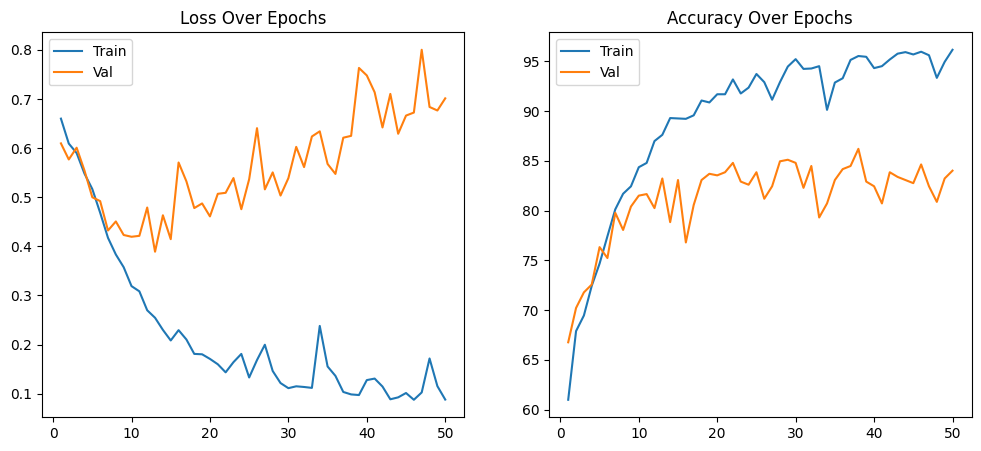


Final Validation Metrics:
Accuracy : 83.23%
Precision: 83.50%
Recall   : 83.23%
F1 Score : 83.30%
Confusion matrix saved to: /content/drive/MyDrive/IMU/confusion_matrix.png


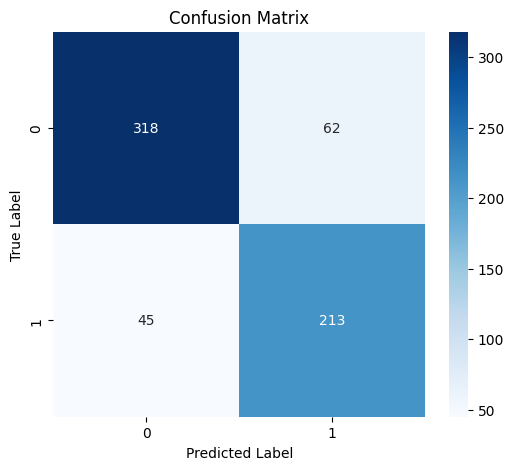

In [9]:
# Load and preprocess raw IMU data
file_path = "/content/drive/MyDrive/IMU/combined_data.xlsx"
frames, labels, class_weights, raw_data = load_and_preprocess_data(file_path)

# Convert framed data into a DataFrame format for training
df = build_a_frame_dict(frames, labels)
num_classes = len(np.unique(labels))

# Prepare dataloaders
dataloaders = prepare_dataloaders(df, batch_size=8)

# Initialize model and optimizer
model = TransformerModel(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Train the model
trained_model, history = train_model(model, dataloaders, optimizer, class_weights, num_epochs=50)

# Plot training/validation metrics
plot_metrics(history)

# Evaluate final model performance and save confusion matrix
evaluate_and_plot_confusion_matrix(
    trained_model,
    dataloaders['val'],
    class_names=[str(i) for i in range(num_classes)],
    save_path="/content/drive/MyDrive/IMU/confusion_matrix.png"
)

# Save the trained model
torch.save(trained_model.state_dict(), "/content/drive/MyDrive/IMU/transformer_model_gaitAnalysis.pth")
